In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("pg_paragraphs.csv")
df.head()

,paragraph
0,One of the most important things I didn't unde...
1,Teachers and coaches implicitly told us the re...
2,It's obviously true that the returns for perfo...
3,You can't understand the world without underst...
4,It may seem as if there are a lot of different...


In [3]:
df["length"] = df["paragraph"].str.len()
df.head()

,paragraph,length
0,One of the most important things I didn't unde...,155
1,Teachers and coaches implicitly told us the re...,313
2,It's obviously true that the returns for perfo...,429
3,You can't understand the world without underst...,178
4,It may seem as if there are a lot of different...,182


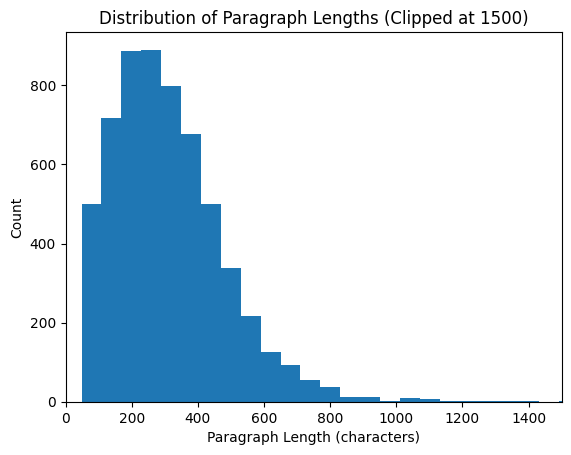

In [4]:
import matplotlib.pyplot as plt

df['length'] = df['paragraph'].str.len()

plt.hist(df['length'], bins=1000)
plt.xlim(0, 1500)  # show only up to 1500 characters
plt.xlabel("Paragraph Length (characters)")
plt.ylabel("Count")
plt.title("Distribution of Paragraph Lengths (Clipped at 1500)")
plt.show()

In [5]:
filtered_df = df[(df['length'] >= 150) & (df['length'] <= 800)]

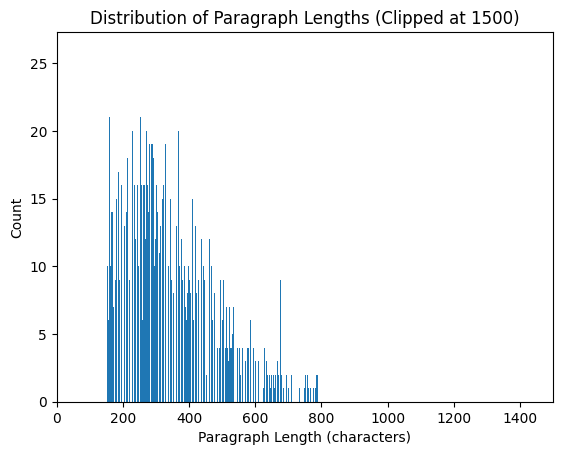

In [6]:
plt.hist(filtered_df['length'], bins=1000)
plt.xlim(0, 1500)  # show only up to 1500 characters
plt.xlabel("Paragraph Length (characters)")
plt.ylabel("Count")
plt.title("Distribution of Paragraph Lengths (Clipped at 1500)")
plt.show()

In [7]:
import openai
from openai import OpenAI
import time
import os
from dotenv import load_dotenv

In [8]:
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY")
)

In [9]:
def get_question_from_gpt(paragraph):
    prompt = f"""Given the following paragraph, generate a concise, insightful question that this paragraph could be an answer to.

Paragraph:
\"\"\"{paragraph}\"\"\"

Question:"""

    try:
        response = client.chat.completions.create(  # fallback method if responses still missing
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a helpful assistant that generates concise questions based on paragraphs."},
                {"role": "user", "content": prompt},
            ],
            temperature=0.7,
            max_tokens=60,
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print("GPT is confused again:", e)
        return None

In [10]:
# Add question column
filtered_df["question"] = filtered_df["paragraph"].apply(lambda p: get_question_from_gpt(p) if isinstance(p, str) else None)

# Optional: Save it to a new CSV
filtered_df.to_csv("pg_question_pairs.csv", index=False)

print("✨ Question generation complete.")

✨ Question generation complete.


/var/folders/nk/5zcc814x561cbxxgrncjyscw0000gn/T/ipykernel_44286/1340360635.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["question"] = filtered_df["paragraph"].apply(lambda p: get_question_from_gpt(p) if isinstance(p, str) else None)


In [11]:
filtered_df.head()


,paragraph,length,question
0,One of the most important things I didn't unde...,155,What realization did the author have about per...
1,Teachers and coaches implicitly told us the re...,313,What misconception do teachers and coaches oft...
2,It's obviously true that the returns for perfo...,429,What is the nature of superlinear returns in v...
3,You can't understand the world without underst...,178,What concept is essential for understanding th...
4,It may seem as if there are a lot of different...,182,What are the two fundamental causes of superli...


In [12]:
import json

# --- helper: convert one row to chat format -----------------
def to_chat_example(row):
    return {
        "messages": [
            {"role": "user",      "content": row["question"]},
            {"role": "assistant", "content": row["paragraph"]}
        ]
    }

# --- build list of training examples ------------------------
chat_examples = (
    filtered_df
      .apply(to_chat_example, axis=1)   # convert every row
      .tolist()                         # turn Series → list
)

# --- write out as newline‑delimited JSON --------------------
out_path = "fine_tune_data.jsonl"
with open(out_path, "w", encoding="utf‑8") as f:
    for ex in chat_examples:
        f.write(json.dumps(ex, ensure_ascii=False) + "\n")

print(f"Saved {len(chat_examples)} examples → {out_path}")

Saved 4846 examples → fine_tune_data.jsonl
